In [1]:
%set_env LAL_DATA_PATH="/Users/qianhu/Documents/lalsuite-extra-master/data/lalsimulation/"
import os
os.environ['LAL_DATA_PATH'] = "/Users/qianhu/Documents/lalsuite-extra-master/data/lalsimulation/"

import numpy as np
import matplotlib.pyplot as plt
import time
import pycbc
from pycbc.types import FrequencySeries
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform

from gstlal import chirptime
from functools import partial


import h5py
import scipy

import bilby
from bilby.gw import utils as gwutils
from pesummary.gw.conversions import spins as pespin
from multiprocessing import Pool
import multiprocessing
from functools import partial
from bilby.gw import conversion

import torch
import os
# cit: '/home/qian.hu/neuron_process_waveform/npf_GWwaveform'
# local: '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/'
try:
    os.chdir('/home/qian.hu/neuron_process_waveform/npf_GWwaveform/')
except:
    os.chdir('/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/')
from gw.utils import gwutils as npgwutils
from gw.utils import gwgenerator
from npf.utils.helpers import rescale_range

import logging

env: LAL_DATA_PATH="/Users/qianhu/Documents/lalsuite-extra-master/data/lalsimulation/"


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Mix test

In [3]:
model_path = "/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/run0310_IMRSUR_5ctxt_R32/"
npmodel_dict = gwgenerator.get_trained_gwmodels(model_path,device='cpu')
model = npmodel_dict['plus_real']


NameError: name 'gwgenerator' is not defined

In [28]:
duration=32
f_lower=10*2
sampling_frequency=4096*2
ifos = bilby.gw.detector.InterferometerList(['L1'])
det = ifos[0]
det.duration = duration
det.sampling_frequency=sampling_frequency
det.frequency_mask = det.frequency_array>=f_lower
mask = det.frequency_mask
freq_array = det.frequency_array[mask]

injection_parameters = {'chirp_mass': 20,
 'mass_ratio': 0.4,
 'a_1': 0.58817513918906,
 'a_2': 0.3618136183509149,
 'tilt_1': 1.5721118014736555,
 'tilt_2': 0.6209483780316792,
 'phi_12': 0.497541312882614,
 'phi_jl': 2.727769314864493,
 'theta_jn': 1.2076899194027677,
 'psi': 2.592123436585328,
 'phase': 3.153492039022807,
 'ra': 4.2400911,
 'dec': -0.39120439,
 'luminosity_distance': 320,
 'geocent_time': 1256779567.5339382}

injection_parameters_train = {'chirp_mass': 15.415, #15.41495791257351
 'mass_ratio': 0.4,
 'a_1': 0.58817513918906,
 'a_2': 0.3618136183509149,
 'tilt_1': 1.5721118014736555,
 'tilt_2': 0.6209483780316792,
 'phi_12': 0.497541312882614,
 'phi_jl': 2.727769314864493,
 'theta_jn': 1.2076899194027677,
 'psi': 2.592123436585328,
 'phase': 3.153492039022807,
 'ra': 4.2400911,
 'dec': -0.39120439,
 'luminosity_distance': 320,
 'geocent_time': 1256779567.5339382}

injection_parameters = injection_parameters_train
approx = 'IMRPhenomXPHM' # IMRPhenomXPHM IMRPhenomPv2
approx_under = 'SsurNRv4PHM' # SsurNRv4PHM SsurNRv4P
f_ref = 50
f_lower = 20
waveform_arguments1 = dict(waveform_approximant=approx,
                              reference_frequency=f_ref, minimum_frequency=f_lower)
waveform_arguments2 = dict(waveform_approximant=approx_under,
                              reference_frequency=f_ref, minimum_frequency=f_lower)

waveform_generator1 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments1)

waveform_generator2 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments2)

truth_1_dict = waveform_generator1.frequency_domain_strain(injection_parameters)
truth_2_dict = waveform_generator2.frequency_domain_strain(injection_parameters)
#for key, errors in truth_2_dict.items():
#    truth_2_dict[key] = npgwutils.get_shifted_h2_zeropad(truth_1_dict[key], truth_2_dict[key], det)
    
    
#truth_1 = truth_1_dict['plus'].real
#truth_2 = truth_2_dict['plus'].real

In [29]:
import time
hp1 = truth_1_dict['plus']
hp2 = truth_2_dict['plus']

In [30]:
t1 = time.time()
print(npgwutils.get_dtdphi_withift_zeropad(hp1, hp2, det, zero_pad_factor=15))
t2 = time.time()
print(f'time cost: {t2-t1}')

(-0.0009841848550919963, 0.30981981129623637)
time cost: 0.7971620559692383


In [31]:
t1 = time.time()
print(npgwutils.get_dtdphi_withift_zeropad(hp1, hp2, det, zero_pad_factor=7))
t2 = time.time()
print(f'time cost: {t2-t1}')

(-0.00099181466798548, 0.31367877403370215)
time cost: 0.35112690925598145


In [32]:
t1 = time.time()
print(npgwutils.get_dtdphi_withift_zeropad(hp1, hp2, det, zero_pad_factor=3))
t2 = time.time()
print(f'time cost: {t2-t1}')

(-0.0009460395085945095, 0.2906296720719649)
time cost: 0.19682097434997559


In [33]:
t1 = time.time()
print(npgwutils.get_dtdphi_withift_zeropad(hp1, hp2, det, zero_pad_factor=1))
t2 = time.time()
print(f'time cost: {t2-t1}')

(-0.0009155238513027797, 0.2754144740058227)
time cost: 0.08645200729370117


In [34]:
t1 = time.time()
print(npgwutils.get_dtdphi_withift_zeropad(hp1, hp2, det, zero_pad_factor=0))
t2 = time.time()
print(f'time cost: {t2-t1}')

(-0.0009765625, 0.30597116534336066)
time cost: 0.04338884353637695


In [4]:
import time

def scale_waveform(target_mass, base_f, base_h, base_mass):
    mratio = target_mass/base_mass
    target_f = base_f / mratio
    target_h = base_h * mratio**2

    return target_f, target_h

def monochromatize_waveform(farray, harray, chirp_mass):
    c=299792458
    G=6.67e-11
    A=(np.pi)**(-2/3)*np.sqrt(5/24)
    amp = A*c*(G*chirp_mass/c**3)**(5/6) * farray**(-7/6)
    h_mono = harray / amp
    f_mono = farray**(-5/3) * 1e3

    return f_mono, h_mono

def unmonochromatize_waveform(f_mono, h_mono, chirp_mass):
    c=299792458
    G=6.67e-11
    A=(np.pi)**(-2/3)*np.sqrt(5/24)
    farray = (f_mono/1e3)**(-3/5)
    amp = A*c*(G*chirp_mass/c**3)**(5/6) * farray**(-7/6)
    harray = h_mono * amp

    return farray, harray

def resample_mono_fdwaveforms(f_mono, h_mono):
    f_mono_new = f_mono[::-1]
    h_mono_new = h_mono[::-1]

    fs_min = min(f_mono_new)
    fs_max = max(f_mono_new)

    fs_rd = 0.1 # for M=25, ringfown freq=0.015. Take 0.02 here
    new_fs1 = np.linspace(fs_min, fs_rd, int(len(f_mono_new)*fs_rd/(fs_max-fs_min)) )
    new_fs2 = np.linspace(fs_rd, fs_max, len(f_mono_new)//10)
    new_fs = np.append(new_fs1,new_fs2[1:])

    interpolator = scipy.interpolate.CubicSpline(f_mono_new, h_mono_new)
    new_h = interpolator(new_fs)

    return new_fs[::-1], new_h[::-1]
    #return new_fs, new_h

def unresample_mono_fdwaveforms(f_mono_resampled, h_mono_resampled, f_mono):
    interpolator = scipy.interpolate.CubicSpline(f_mono_resampled[::-1], h_mono_resampled[::-1])
    h_mono = interpolator(f_mono)
    return h_mono


def mix_waveforms(farray, h1_dict, h2_dict, mode, part, fraction=0.01, probe=False):
    l = len(farray)
    
    farray_m1to1 = rescale_range(farray, (farray.min(),farray.max()), (-1,1))
    ctxtindex = np.arange(0,l,int(1/fraction))
    ffarray = np.array(list(zip(farray_m1to1[ctxtindex], farray_m1to1[ctxtindex]))).flatten()
    if part == 'real':
        if probe:
            return ffarray, np.real(np.array(list(zip(h1_dict[mode][ctxtindex], h2_dict[mode][ctxtindex]))).flatten()),\
                    np.array(list(zip(farray[ctxtindex], farray[ctxtindex]))).flatten()
        else:
            return ffarray, np.real(np.array(list(zip(h1_dict[mode][ctxtindex], h2_dict[mode][ctxtindex]))).flatten())
    elif part == 'imag':
        if probe:
            return ffarray, np.real(np.array(list(zip(h1_dict[mode][ctxtindex], h2_dict[mode][ctxtindex]))).flatten()),\
                    np.array(list(zip(farray[ctxtindex], farray[ctxtindex]))).flatten()
        else:
            return ffarray, np.imag(np.array(list(zip(h1_dict[mode][ctxtindex], h2_dict[mode][ctxtindex]))).flatten())
        
def mix_waveforms2(farray, h1, h2, fraction=0.01):
    l = len(farray)
    
    farray_m1to1 = rescale_range(farray, (farray.min(),farray.max()), (-1,1))
    ctxtindex = np.arange(0,l,int(1/fraction))
    ffarray = np.array(list(zip(farray_m1to1[ctxtindex], farray_m1to1[ctxtindex]))).flatten()
    
    return ffarray, np.array(list(zip(h1[ctxtindex], h2[ctxtindex]))).flatten()

In [5]:
mtot = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(
            injection_parameters['chirp_mass'],
            injection_parameters['mass_ratio']
        )
npmodel_total_mass=40
mratio = mtot/npmodel_total_mass

#waveform_generator1.waveform_arguments['minimum_frequency'] /= mratio
#waveform_generator2.waveform_arguments['minimum_frequency'] /= mratio

fmin4inj = waveform_generator1.waveform_arguments['minimum_frequency']
context_f_low = 20
waveform_generator1.waveform_arguments['minimum_frequency'] = context_f_low
waveform_generator2.waveform_arguments['minimum_frequency'] = context_f_low

#waveform_generator1.waveform_arguments['reference_frequency'] *= mratio
#waveform_generator2.waveform_arguments['reference_frequency'] *= mratio

#if fmin4inj>context_f_low: 
#    logging.warning(f"Mtot={mtot} < Training Mtot {npmodel_total_mass}, therefore changing starting frequency to {fmin4inj}Hz, which is higher than given {context_f_low}Hz.")


context_frequency_array = waveform_generator1.frequency_array
mask = context_frequency_array>=fmin4inj
d_l = injection_parameters['luminosity_distance']
injection_parameters['luminosity_distance'] = 100
injection_parameters['chirp_mass'] = injection_parameters['chirp_mass']/mratio
print("new mc", injection_parameters['chirp_mass'])

h_dict_context1 = waveform_generator1.frequency_domain_strain(injection_parameters)
h_dict_context2 = waveform_generator2.frequency_domain_strain(injection_parameters)
t1=time.time()

for key, errors in h_dict_context2.items():
    h_dict_context2[key] = npgwutils.get_shifted_h2_zeropad(h_dict_context1[key], h_dict_context2[key], det)
t2=time.time()

new mc 15.414957912573508


In [10]:
farray0 = context_frequency_array[mask]
h1 = h_dict_context1['plus'][mask].real
h2 = h_dict_context2['plus'][mask].real

# monochromatize
f_mono, h1_mono = monochromatize_waveform(farray0, h1, injection_parameters['chirp_mass'])
f_mono, h2_mono = monochromatize_waveform(farray0, h2, injection_parameters['chirp_mass'])

#h1_mono = h1_mono.real
#h2_mono = h2_mono.real

f_mono_resampled, h1_mono_resampled = resample_mono_fdwaveforms(f_mono, h1_mono)
f_mono_resampled, h2_mono_resampled = resample_mono_fdwaveforms(f_mono, h2_mono)

context_fraction = 0.3
ff_mono_resampled, hh_mono_resampled = mix_waveforms2(f_mono_resampled, h1_mono_resampled, h2_mono_resampled, context_fraction)


target_f_mono_resampled = rescale_range(f_mono_resampled, (f_mono_resampled.min(),f_mono_resampled.max()), (-1,1))
t1=time.time()
mean_resampled, std_resampled = npgwutils.get_predictions(model,
                                    torch.from_numpy(ff_mono_resampled).unsqueeze(-1).unsqueeze(0).type(torch.float32), 
                                    torch.from_numpy(hh_mono_resampled).unsqueeze(-1).unsqueeze(0).type(torch.float32), 
                                    torch.from_numpy(target_f_mono_resampled).unsqueeze(-1).unsqueeze(0).type(torch.float32), 
                                    1)
t2=time.time()
print(f"time cost: {t2-t1}")


time cost: 0.3164210319519043


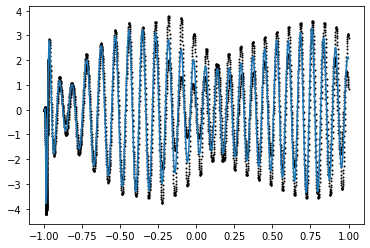

In [11]:
plt.plot(target_f_mono_resampled, mean_resampled)
plt.scatter(ff_mono_resampled, hh_mono_resampled, color='k', s=1)


In [12]:
farray2, mean_scaled = unmonochromatize_waveform(f_mono_resampled, mean_resampled, injection_parameters['chirp_mass']/1) #mratio
farray2, std_scaled = unmonochromatize_waveform(f_mono_resampled, std_resampled, injection_parameters['chirp_mass']/1)



(10.0, 50.0)

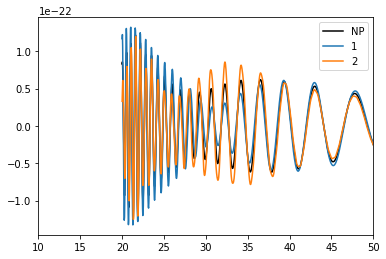

In [13]:

plt.plot(farray2, mean_scaled, label='NP',color='k')
plt.plot(farray0, h1.real, label='1')
plt.plot(farray0, h2.real, label='2')

plt.legend()
plt.xlim(10,50)

In [35]:
farray3, mean = scale_waveform(target_mass=mtot, base_f=farray2, base_h=mean_scaled, base_mass=npmodel_total_mass)
farray3, std = scale_waveform(target_mass=mtot, base_f=farray2, base_h=std_scaled, base_mass=npmodel_total_mass)

farray31, h1ts = scale_waveform(target_mass=mtot, base_f=farray0, base_h=h1, base_mass=npmodel_total_mass)
farray32, h2ts = scale_waveform(target_mass=mtot, base_f=farray0, base_h=h2, base_mass=npmodel_total_mass)


(10.0, 50.0)

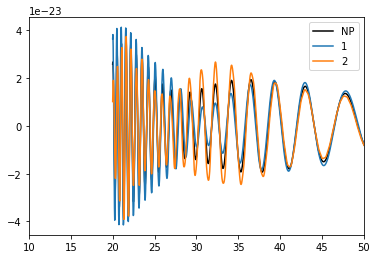

In [36]:
plt.plot(farray3, mean/3.2, label='NP',color='k')
plt.plot(farray31, h1ts/3.2, label='1')
plt.plot(farray32, h2ts/3.2, label='2')


plt.legend()
plt.xlim(10,50)

(10.0, 50.0)

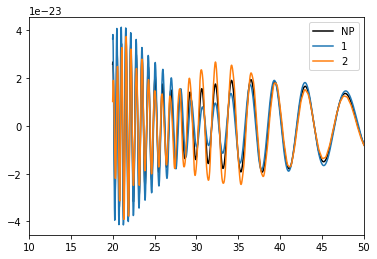

In [37]:
plt.plot(farray3, mean/3.2, label='NP',color='k')
plt.plot(farray0, truth_1[mask], label='1')
plt.plot(farray0, truth_2[mask], label='2')


plt.legend()
plt.xlim(10,50)

In [38]:
farray01, h1sc = scale_waveform(target_mass=mtot, base_f=farray0, base_h=h1, base_mass=npmodel_total_mass)
farray02, h2sc = scale_waveform(target_mass=mtot, base_f=farray0, base_h=h2, base_mass=npmodel_total_mass)


(10.0, 50.0)

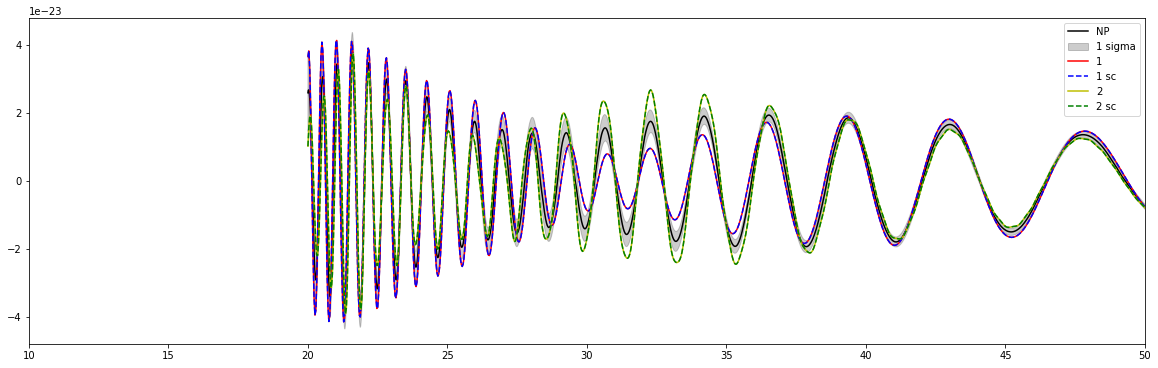

In [39]:
plt.figure(figsize=(20,6))
plt.plot(farray3, mean/3.2, label='NP',color='k')
plt.fill_between(farray3, (mean-std)/3.2, (mean+std)/3.2, label='1 sigma',color='k', alpha=0.2)

plt.plot(farray0, truth_1[mask], label='1', color='r')
plt.plot(farray01, h1sc/3.2, label='1 sc', color='b', linestyle='--')


plt.plot(farray0, truth_2[mask], label='2', color='y')
plt.plot(farray02, h2sc/3.2, label='2 sc', color='g', linestyle='--')

plt.legend()
plt.xlim(10,50)

In [27]:
#zerolenth = len(np.where(context_frequency_array<min(fmin4inj,context_f_low))[0])
zerolenth = len(np.where(context_frequency_array<fmin4inj)[0])
zero_paddings = np.zeros(zerolenth)

mean_dict[label] = np.append(zero_paddings, mean_at_freq) * 100 / d_l
#mean_dict[label] = mean_resampled
std_dict[label] = np.append(zero_paddings, std_at_freq) * 100 / d_l


NameError: name 'mean_at_freq' is not defined

In [ ]:

#interpolator_mean = scipy.interpolate.CubicSpline(farray3, mean)
interpolator_mean = scipy.interpolate.CubicSpline(farray3, mean)
mean_at_freq = interpolator_mean(context_frequency_array[mask])

interpolator_std = scipy.interpolate.CubicSpline(farray3, std)
std_at_freq = interpolator_std(context_frequency_array[mask])


In [ ]:
waveform_generator1.waveform_arguments['reference_frequency'] /= mratio
waveform_generator2.waveform_arguments['reference_frequency'] /= mratio
injection_parameters['luminosity_distance']=d_l
injection_parameters['chirp_mass'] = injection_parameters['chirp_mass']*mratio

new mc 15.41495791257351

--- Loading plus_real/ConvCNP/run_0 ---

plus_real/ConvCNP/run_0 | best epoch: 53 | train loss: 963.8841 | valid loss: 5833.8574 | test log likelihood: -11169.7719

--- Loading plus_imag/ConvCNP/run_0 ---

plus_imag/ConvCNP/run_0 | best epoch: 53 | train loss: 1405.9768 | valid loss: 6278.9118 | test log likelihood: -12922.3249

--- Loading cross_real/ConvCNP/run_0 ---

cross_real/ConvCNP/run_0 | best epoch: 53 | train loss: 5844.2346 | valid loss: 10770.8468 | test log likelihood: -15702.9021

--- Loading cross_imag/ConvCNP/run_0 ---

cross_imag/ConvCNP/run_0 | best epoch: 72 | train loss: 5302.8279 | valid loss: 14434.7345 | test log likelihood: -19813.4421


/Users/qianhu/opt/anaconda3/envs/igwn-py39/lib/python3.9/site-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


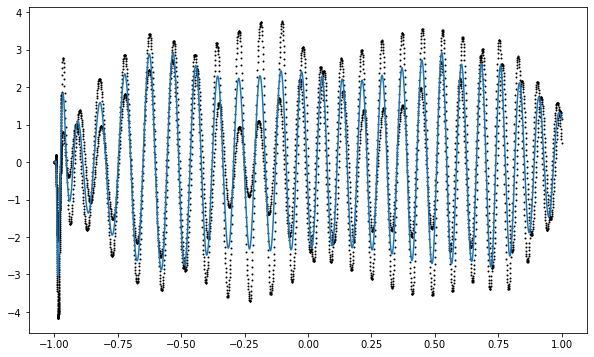

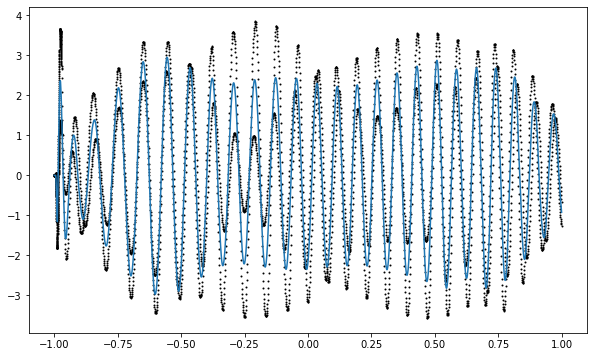

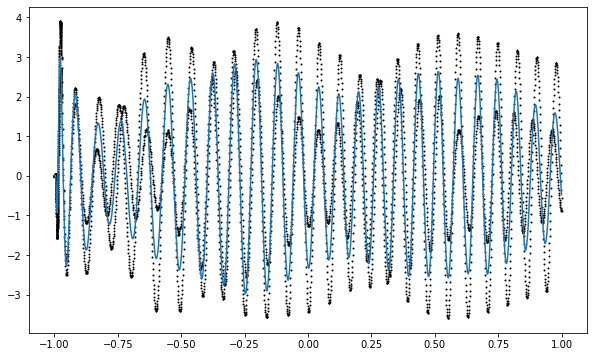

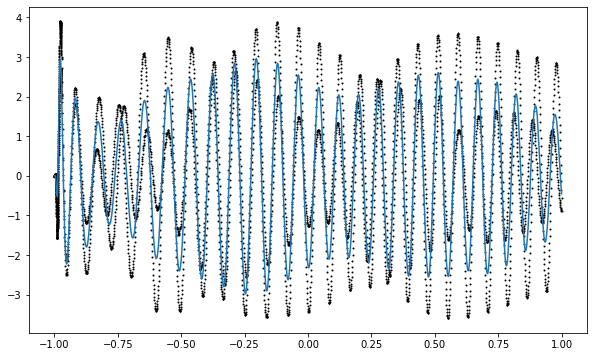

context waveform time cost: 1.561178207397461s
shifting waveform time cost: 3.3198540210723877s
prediction time cost: 1.2817115783691406s
total time cost: 9.226978063583374s


In [118]:
t0=time.time()
mtot = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(
            injection_parameters['chirp_mass'],
            injection_parameters['mass_ratio']
        )
npmodel_total_mass=40
mratio = mtot/npmodel_total_mass

#waveform_generator1.waveform_arguments['minimum_frequency'] /= mratio
#waveform_generator2.waveform_arguments['minimum_frequency'] /= mratio

fmin4inj = waveform_generator1.waveform_arguments['minimum_frequency']
context_f_low = 20
waveform_generator1.waveform_arguments['minimum_frequency'] = context_f_low
waveform_generator2.waveform_arguments['minimum_frequency'] = context_f_low

waveform_generator1.waveform_arguments['reference_frequency'] *= mratio
waveform_generator2.waveform_arguments['reference_frequency'] *= mratio

#if fmin4inj>context_f_low: 
#    logging.warning(f"Mtot={mtot} < Training Mtot {npmodel_total_mass}, therefore changing starting frequency to {fmin4inj}Hz, which is higher than given {context_f_low}Hz.")


context_frequency_array = waveform_generator1.frequency_array
mask = context_frequency_array>=fmin4inj
d_l = injection_parameters['luminosity_distance']
injection_parameters['luminosity_distance'] = 100
injection_parameters['chirp_mass'] = injection_parameters['chirp_mass']/mratio
print("new mc", injection_parameters['chirp_mass'])

h_dict_context1 = waveform_generator1.frequency_domain_strain(injection_parameters)
h_dict_context2 = waveform_generator2.frequency_domain_strain(injection_parameters)
t1=time.time()

for key, errors in h_dict_context2.items():
    h_dict_context2[key] = npgwutils.get_shifted_h2_zeropad(h_dict_context1[key], h_dict_context2[key], det)
t2=time.time()

farray0 = context_frequency_array[mask]
probe_h = h_dict_context1['cross'][mask]

hmono_dict_context1 = {}
hmono_dict_context2 = {}
for mode2scale in ['plus','cross']:
    # mask
    h_dict_context1[mode2scale] = h_dict_context1[mode2scale][mask]
    h_dict_context2[mode2scale] = h_dict_context2[mode2scale][mask]


    # scale to training mass
    #scaled_context_f, h_dict_context1[mode2scale] = scale_waveform(target_mass=npmodel_total_mass, base_f=farray0, base_h=h_dict_context1[mode2scale], base_mass=mtot)
    #scaled_context_f, h_dict_context2[mode2scale] = scale_waveform(target_mass=npmodel_total_mass, base_f=farray0, base_h=h_dict_context2[mode2scale], base_mass=mtot)

    # monochromatize
    f_mono, hmono_dict_context1[mode2scale] = monochromatize_waveform(farray0, h_dict_context1[mode2scale], injection_parameters['chirp_mass'])
    f_mono, hmono_dict_context2[mode2scale] = monochromatize_waveform(farray0, h_dict_context2[mode2scale], injection_parameters['chirp_mass'])

    probh1 = h_dict_context1[mode2scale]
    # resample
    f_mono_resampled, h1_mono_resampled_real = resample_mono_fdwaveforms(f_mono, np.real(hmono_dict_context1[mode2scale]))
    f_mono_resampled, h1_mono_resampled_imag = resample_mono_fdwaveforms(f_mono, np.imag(hmono_dict_context1[mode2scale]))
    h_dict_context1[mode2scale] = h1_mono_resampled_real + h1_mono_resampled_imag*1j
    
    f_mono_resampled, h2_mono_resampled_real = resample_mono_fdwaveforms(f_mono, np.real(hmono_dict_context2[mode2scale]))
    f_mono_resampled, h2_mono_resampled_imag = resample_mono_fdwaveforms(f_mono, np.imag(hmono_dict_context2[mode2scale]))
    h_dict_context2[mode2scale] = h2_mono_resampled_real + h2_mono_resampled_imag*1j
    


h_dict_context_components={}
context_fraction = 0.3
ff_mono_resampled, h_dict_context_components['plus_real'] = mix_waveforms(f_mono_resampled, h_dict_context1, h_dict_context2, 'plus', 'real', context_fraction)
ff_mono_resampled, h_dict_context_components['plus_imag'] = mix_waveforms(f_mono_resampled, h_dict_context1, h_dict_context2, 'plus', 'imag', context_fraction)
ff_mono_resampled, h_dict_context_components['cross_real'] = mix_waveforms(f_mono_resampled, h_dict_context1, h_dict_context2, 'cross', 'real', context_fraction)
ff_mono_resampled, h_dict_context_components['cross_imag'],cnmf = mix_waveforms(f_mono_resampled, h_dict_context1, h_dict_context2, 'cross', 'imag', context_fraction,True)


model_path = "/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/run0221_5percent/"
model_path = "/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/run0215_2/"
npmodel_dict = npgwutils.get_trained_gwmodels(model_path,device='cpu')


mean_dict={}
std_dict={}
for label,h_mono_resampled in h_dict_context_components.items():
    model = npmodel_dict[label]
    t3 = time.time()
    
    target_f_mono_resampled = rescale_range(f_mono_resampled, (f_mono_resampled.min(),f_mono_resampled.max()), (-1,1))
    #target_f_mono_resampled = rescale_range(f_mono, (f_mono.min(),f_mono.max()), (-1,1))
    mean_resampled, std_resampled = npgwutils.get_predictions(model,
                                        torch.from_numpy(ff_mono_resampled).unsqueeze(-1).unsqueeze(0).type(torch.float32), 
                                        torch.from_numpy(h_mono_resampled).unsqueeze(-1).unsqueeze(0).type(torch.float32), 
                                        torch.from_numpy(target_f_mono_resampled).unsqueeze(-1).unsqueeze(0).type(torch.float32), 
                                        1)
    t4 = time.time()
    #mean_resampled = mean_resampled[::-1]
    #std_resampled = std_resampled[::-1]
    #mean_mono = self.unresample_mono_fdwaveforms(f_mono_resampled, mean_resampled, f_mono)
    #std_mono = self.unresample_mono_fdwaveforms(f_mono_resampled, std_resampled, f_mono)

    #mean_resampled = mean_resampled[::2]
    #std_resampled = std_resampled[::2]

    #[::-1]
    farray2, mean_scaled = unmonochromatize_waveform(f_mono_resampled, mean_resampled, injection_parameters['chirp_mass']/1) #mratio
    farray2, std_scaled = unmonochromatize_waveform(f_mono_resampled, std_resampled, injection_parameters['chirp_mass']/1)


    # unscale to injection mass
    # farray3 should == farray (?)
    farray3, mean = scale_waveform(target_mass=mtot, base_f=farray2, base_h=mean_scaled, base_mass=npmodel_total_mass)
    farray3, std = scale_waveform(target_mass=mtot, base_f=farray2, base_h=std_scaled, base_mass=npmodel_total_mass)

    #interpolator_mean = scipy.interpolate.CubicSpline(farray3, mean)
    interpolator_mean = scipy.interpolate.CubicSpline(farray3, mean)
    mean_at_freq = interpolator_mean(context_frequency_array[mask])

    interpolator_std = scipy.interpolate.CubicSpline(farray3, std)
    std_at_freq = interpolator_std(context_frequency_array[mask])

    
    
    #zerolenth = len(np.where(context_frequency_array<min(fmin4inj,context_f_low))[0])
    zerolenth = len(np.where(context_frequency_array<fmin4inj)[0])
    zero_paddings = np.zeros(zerolenth)

    mean_dict[label] = np.append(zero_paddings, mean_at_freq) * 100 / d_l
    #mean_dict[label] = mean_resampled
    std_dict[label] = np.append(zero_paddings, std_at_freq) * 100 / d_l
    
    plt.figure(figsize=(10,6))
    plt.scatter(ff_mono_resampled, h_mono_resampled, color='k', s=1)
    plt.plot(target_f_mono_resampled, mean_resampled)
    plt.show()

h_dict = {}
error_dict = {}
for key in ['plus', 'cross']:
    h_dict[key] = mean_dict[f'{key}_real'] + mean_dict[f'{key}_imag']*1j
    error_dict[key] = std_dict[f'{key}_real'] + std_dict[f'{key}_imag']*1j
    

#waveform_generator1.waveform_arguments['minimum_frequency'] *= mratio
#waveform_generator2.waveform_arguments['minimum_frequency'] *= mratio

waveform_generator1.waveform_arguments['reference_frequency'] /= mratio
waveform_generator2.waveform_arguments['reference_frequency'] /= mratio
injection_parameters['luminosity_distance']=d_l
injection_parameters['chirp_mass'] = injection_parameters['chirp_mass']*mratio

tend = time.time()
print(f"context waveform time cost: {t1-t0}s")
print(f"shifting waveform time cost: {t2-t1}s")
print(f"prediction time cost: {4*(t4-t3)}s")

print(f"total time cost: {tend-t0}s")


In [119]:
mode = 'cross'
plot_wave1 = waveform_generator1.frequency_domain_strain(injection_parameters)[mode]
plot_wave2 = waveform_generator2.frequency_domain_strain(injection_parameters)[mode]
plot_wave2 = npgwutils.get_shifted_h2_zeropad(plot_wave1, plot_wave2, det)


plot_wave1_train = waveform_generator1.frequency_domain_strain(injection_parameters_train)[mode]
plot_wave2_train = waveform_generator2.frequency_domain_strain(injection_parameters_train)[mode]
plot_wave2_train = npgwutils.get_shifted_h2_zeropad(plot_wave1_train, plot_wave2_train, det)

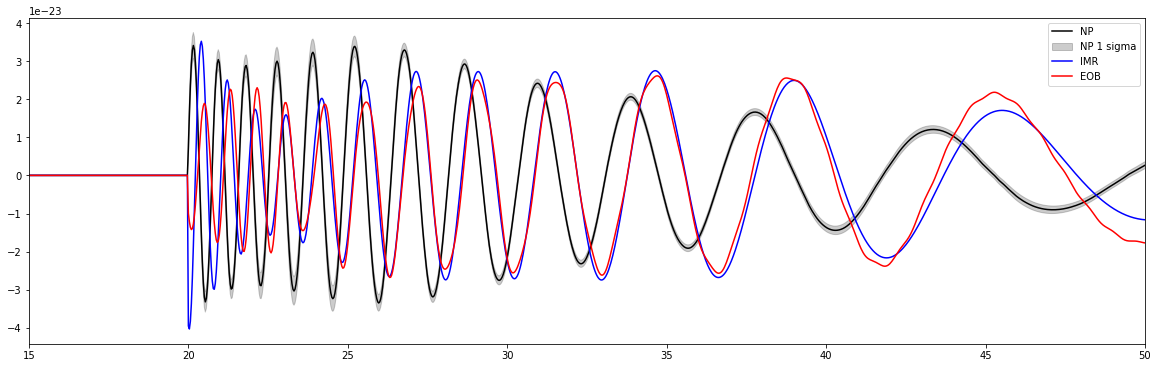

In [120]:
plt.figure(figsize=(20,6))
plt.plot(waveform_generator1.frequency_array, np.imag(h_dict[mode]),label='NP',color='k')
plt.fill_between(waveform_generator1.frequency_array, np.imag(h_dict[mode]-error_dict[mode]),np.imag(h_dict[mode]+error_dict[mode]),
                 label='NP 1 sigma',color='k', alpha=0.2)

plt.plot(waveform_generator1.frequency_array, np.imag(plot_wave1),label='IMR',color='b')
plt.plot(waveform_generator2.frequency_array, np.imag(plot_wave2),label='sur',color='r')

plt.xlim(15,50)

#plt.xlim(400,2000)
#plt.ylim(-1e-25,1e-25)
plt.legend()


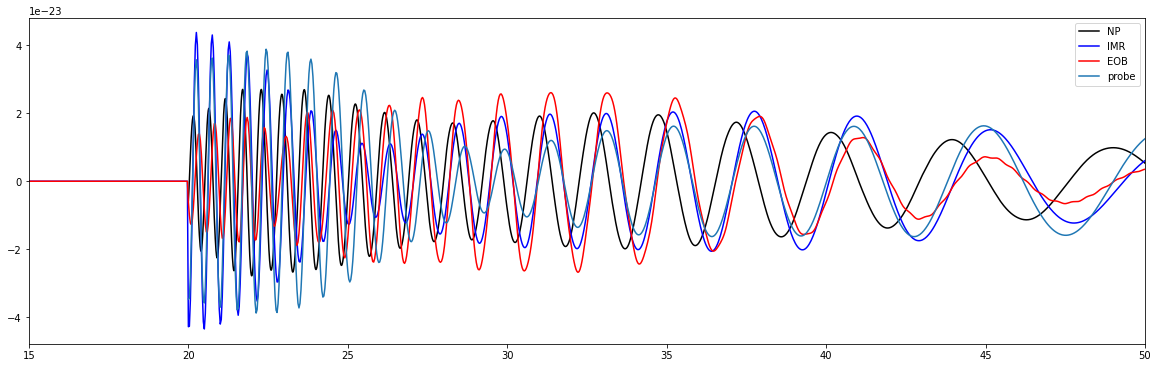

In [121]:
plt.figure(figsize=(20,6))
plt.plot(farray2, mean_scaled/3.2,label='NP',color='k')


plt.plot(waveform_generator1.frequency_array, np.imag(plot_wave1_train),label='IMR',color='b')
plt.plot(waveform_generator2.frequency_array, np.imag(plot_wave2_train),label='sur',color='r')
plt.plot(farray0, np.imag(probe_h)/3.2, label='probe')
plt.xlim(15,50)

#plt.xlim(400,2000)
#plt.ylim(-1e-25,1e-25)
plt.legend()

# Mix context

## waveform

In [47]:
duration=32
f_lower=10*2
sampling_frequency=4096
ifos = bilby.gw.detector.InterferometerList(['L1'])
det = ifos[0]
det.duration = duration
det.sampling_frequency=sampling_frequency
det.frequency_mask = det.frequency_array>=f_lower
mask = det.frequency_mask
freq_array = det.frequency_array[mask]

injection_parameters = {'chirp_mass': 20/1.1572921792698843,# /1.2974411032083721
 'mass_ratio': 0.8,
 'a_1': 0.58817513918906,
 'a_2': 0.3618136183509149,
 'tilt_1': 0.5721118014736555,
 'tilt_2': 0.6209483780316792,
 'phi_12': 0.497541312882614,
 'phi_jl': 2.727769314864493,
 'theta_jn': 1.2076899194027677,
 'psi': 2.592123436585328,
 'phase': 3.153492039022807,
 'ra': 4.2400911,
 'dec': -0.39120439,
 'luminosity_distance': 320,
 'geocent_time': 1256779567.5339382}

mtot = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(
            injection_parameters['chirp_mass'],
            injection_parameters['mass_ratio']
        )
mratio = mtot/40

injection_parameters_40mtot = injection_parameters.copy()
injection_parameters_40mtot['chirp_mass'] /= mratio
injection_parameters_40mtot['geocent_time'] = 0 # avoid cache


#injection_parameters = injection_parameters_40mtot.copy()
#mtot = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(
#            injection_parameters['chirp_mass'],
#            injection_parameters['mass_ratio']
#        )
#mratio = mtot/40

approx = 'IMRPhenomXPHM' # IMRPhenomXPHM IMRPhenomPv2
approx_under = 'NRSur7dq4' # SsurNRv4PHM SsurNRv4P
f_ref = 110
f_lower = 20
f_lower_sur = np.ceil(npgwutils.safe_fmin_NRSur7dq4(injection_parameters))
waveform_arguments1 = dict(waveform_approximant=approx,
                              reference_frequency=f_ref, minimum_frequency=f_lower, mode_array=[[2,2],[2,-2]])
waveform_arguments2 = dict(waveform_approximant=approx_under,
                              reference_frequency=f_ref, minimum_frequency=f_lower_sur, mode_array=[[2,2],[2,-2]])

waveform_generator1 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments1)

waveform_generator2 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments2)

In [38]:
mratio, mtot

(1.0, 40.0)

In [39]:
def scale_waveform(target_mass, base_f, base_h, base_mass):
    mratio = target_mass/base_mass
    target_f = base_f / mratio
    target_h = base_h * mratio**2

    return target_f, target_h

t1=time.time()
h_dict_imr = waveform_generator1.frequency_domain_strain(injection_parameters)
h_dict_sur = waveform_generator2.frequency_domain_strain(injection_parameters)
t11=time.time()
for key in ['plus', 'cross']:
    h_dict_sur[key] = npgwutils.get_shifted_h2_zeropad(h_dict_imr[key], h_dict_sur[key], det, zero_pad_factor=15)
t12=time.time()
print(f"shift time cost: {t12-t11}")
    

#waveform_generator1.waveform_arguments['reference_frequency'] *= mratio
#waveform_generator2.waveform_arguments['reference_frequency'] *= mratio
h_dict_imr_to_shift = waveform_generator1.frequency_domain_strain(injection_parameters_40mtot)
h_dict_sur_to_shift = waveform_generator2.frequency_domain_strain(injection_parameters_40mtot)

for key in ['plus', 'cross']:
    h_dict_sur_to_shift[key] = npgwutils.get_shifted_h2_zeropad(h_dict_imr_to_shift[key], h_dict_sur_to_shift[key], det)
for key in ['plus', 'cross']:
    mask = det.frequency_mask
    farray_ori = waveform_generator2.frequency_array
    farray_shiftedsur, h_dict_sur_to_shift[key] = scale_waveform(mtot, farray_ori[mask], h_dict_sur_to_shift[key][mask], 40)
    farray_shiftedimr, h_dict_imr_to_shift[key] = scale_waveform(mtot, farray_ori[mask], h_dict_imr_to_shift[key][mask], 40)
#waveform_generator1.waveform_arguments['reference_frequency'] /= mratio
#waveform_generator2.waveform_arguments['reference_frequency'] /= mratio


t2=time.time()
print(f"waveform generation and shifting time cost: {t12-t1}")

shift time cost: 1.6045620441436768
waveform generation and shifting time cost: 1.6820261478424072


In [40]:
# local
#path_local_PHM = '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMRsur_PHM_q25a8M40_2N10k/'
path_local_PHM = '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/run0314_IMRSUR_20ctxt_R128/'
path_local_PHM22 = '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/run0319_IMRSUR22_5ctxt_R32/'

#path_local_P = '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMRsur_P_q25a8M40_2N10k/'
#path_local_P = '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/run0215_2/'
#path_local_P = '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/run0221_5percent/'
#path_local_P = '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/run0228_R16/'
#path_local_P = '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/run0228_R32/'

# cit
path_cit_PHM = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMRsur_PHM_q25a8M40_2N10k/'
#path_cit_P = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMRsur_P_q25a8M40_2N10k/'
path_cit_P = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/run0211/'


np_model_path = path_local_PHM22
waveform_generator_np_mix = gwgenerator.NPUeqMixWaveformGenerator(model_path=np_model_path,
                                                          context_waveform_generator1=waveform_generator1,
                                                          context_waveform_generator2=waveform_generator2,
                                                          context_fraction = 0.05,
                                                          example_det = det,
                                                          device='cpu',
                                                          R_DIM=32)



--- Loading plus_real/ConvCNP/run_0 ---

plus_real/ConvCNP/run_0 | best epoch: 191 | train loss: -3056.9855 | valid loss: -1291.3046 | test log likelihood: -3625.5761

--- Loading plus_imag/ConvCNP/run_0 ---

plus_imag/ConvCNP/run_0 | best epoch: 162 | train loss: -7049.1793 | valid loss: -6683.9588 | test log likelihood: -20437.362

--- Loading cross_real/ConvCNP/run_0 ---

cross_real/ConvCNP/run_0 | best epoch: 191 | train loss: -3849.6672 | valid loss: -2435.7177 | test log likelihood: -975.4806

--- Loading cross_imag/ConvCNP/run_0 ---

cross_imag/ConvCNP/run_0 | best epoch: 194 | train loss: -3715.6967 | valid loss: -2637.0177 | test log likelihood: -1584.4071


In [41]:
t1 = time.time()
h_dict, error_dict = waveform_generator_np_mix.frequency_domain_strain(injection_parameters)
t2 = time.time()

print(f"total timecost: {t2-t1}s")

Assuming waveform generator 2 is for NRSur7dq4. Changing starting frequency to 48.0Hz.
Context waveform generation time cost: 0.06784701347351074
Context waveform shifting time cost: 0.08249592781066895
NP prediction time cost: 1.576997995376587
total timecost: 1.9178440570831299s


(30.0, 100.0)

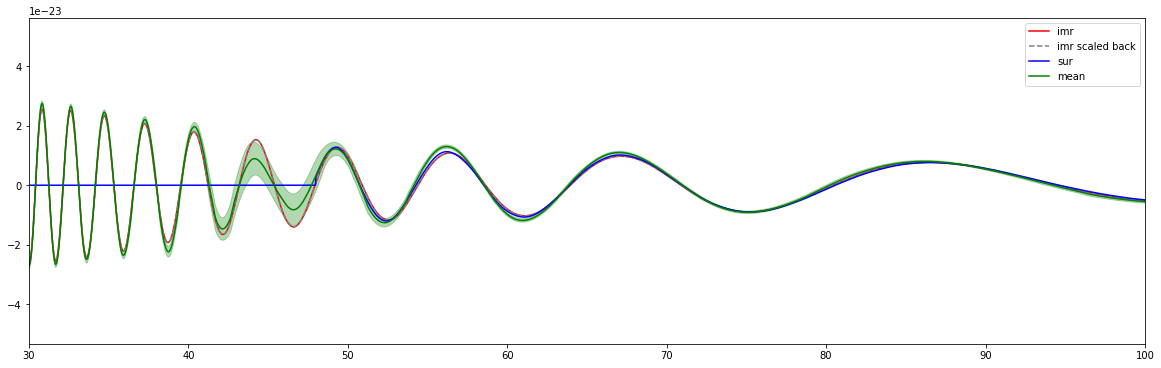

In [44]:
plt.figure(figsize=(20,6))

mode = 'plus'
part = 'real'

if part=='real':
    plt.plot(waveform_generator1.frequency_array, np.real(h_dict_imr[mode]), label='imr',color='r')
    plt.plot(farray_shiftedimr, np.real(h_dict_imr_to_shift[mode]), label='imr scaled back',color='grey',linestyle='--')

    plt.plot(waveform_generator2.frequency_array, np.real(h_dict_sur[mode]), label='sur',color='b')
    #plt.plot(farray_shiftedsur, np.real(h_dict_sur_to_shift[mode]), label='sur',color='b')

    plt.plot(waveform_generator2.frequency_array, np.real(h_dict[mode]), label='mean',color='g')
    plt.fill_between(waveform_generator1.frequency_array,
                    np.real(h_dict[mode]-error_dict[mode]),np.real(h_dict[mode]+error_dict[mode]),
                    alpha=0.3,color='g' )
elif part=='imag':
    plt.plot(waveform_generator1.frequency_array, np.imag(h_dict_imr[mode]), label='imr',color='r')
    #plt.plot(waveform_generator2.frequency_array, np.imag(h_dict_sur[mode]), label='sur',color='b')
    plt.plot(farray_shiftedsur, np.imag(h_dict_sur_to_shift[mode]), label='sur',color='b')
    
    plt.plot(waveform_generator2.frequency_array, np.imag(h_dict[mode]), label='mean',color='g')
    plt.fill_between(waveform_generator1.frequency_array,
                    np.imag(h_dict[mode]-error_dict[mode]),np.imag(h_dict[mode]+error_dict[mode]),
                    alpha=0.3,color='g' )


plt.legend()
#plt.xlim(40,100)
plt.xlim(30,100)

In [48]:
waveform_generator1.frequency_array

array([0.00000000e+00, 3.12500000e-02, 6.25000000e-02, ...,
       2.04793750e+03, 2.04796875e+03, 2.04800000e+03])

(20, 2000)

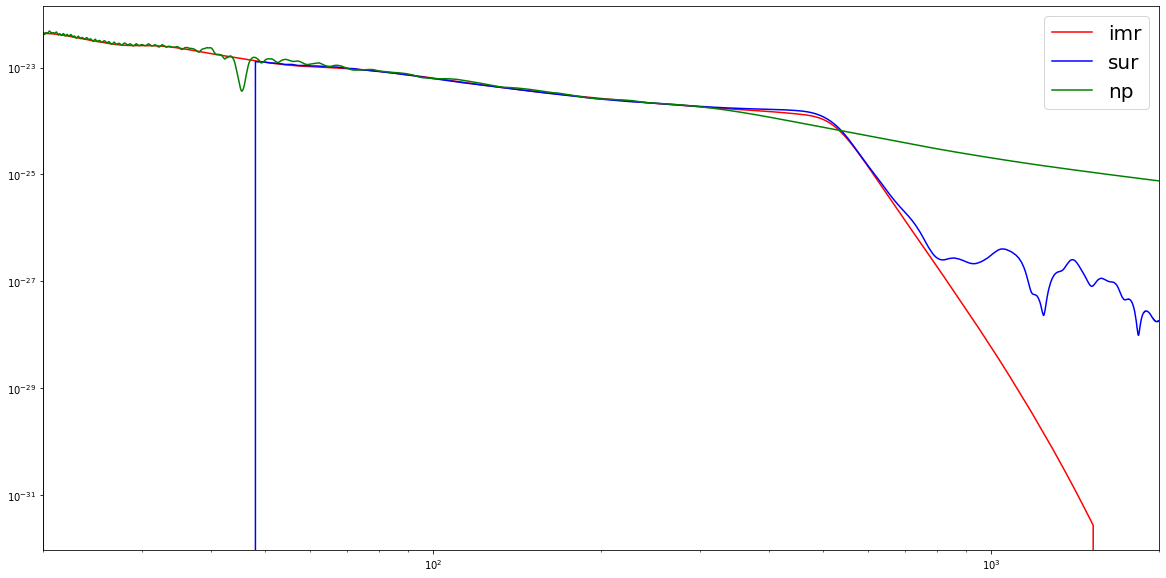

In [45]:
plt.figure(figsize=(20,10))

mode = 'plus'
plt.loglog(waveform_generator1.frequency_array, np.abs(h_dict_imr[mode]), label='imr',color='r')
#plt.loglog(waveform_generator2.frequency_array, np.abs(h_dict_sur[mode]), label='sur',color='b')
plt.loglog(farray_shiftedsur, np.abs(h_dict_sur_to_shift[mode]), label='sur',color='b')

plt.loglog(waveform_generator1.frequency_array, np.abs(h_dict[mode]), label='np',color='g')


plt.legend(fontsize=20)
plt.xlim(20,2000)

## percentile

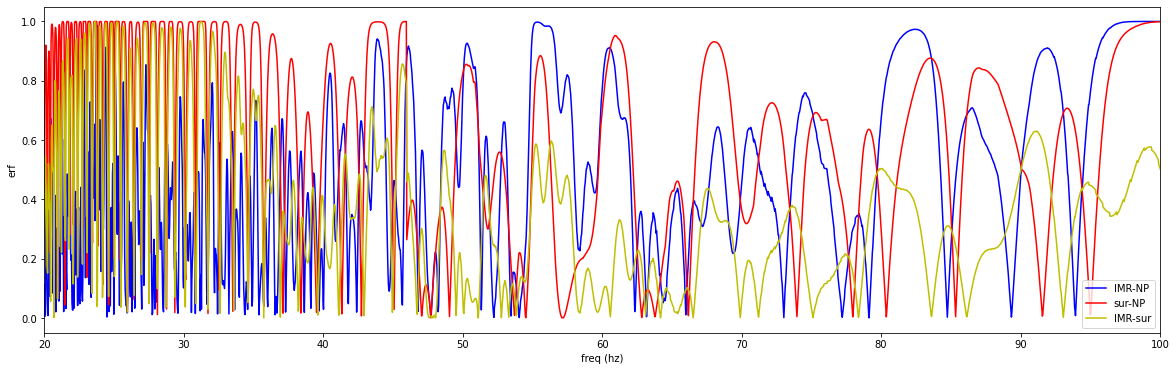

In [48]:
plt.figure(figsize=(20,6))

mode = 'plus'
part = 'real'

testfmin = 20
testfhigh = 400
testmask1 = waveform_generator1.frequency_array>testfmin
testmask2 = waveform_generator1.frequency_array<testfhigh
testmask = testmask1*testmask2

testfreqs = waveform_generator1.frequency_array[testmask]

if part=='real':
    interpolator_surshifted = scipy.interpolate.CubicSpline(farray_shiftedsur, np.real(h_dict_sur_to_shift[mode]))


    sigma = np.real(error_dict[mode][testmask])
    diff1 = abs(np.real(h_dict_imr[mode][testmask]) - np.real(h_dict[mode][testmask]))
    diff2 = abs(np.real(h_dict[mode][testmask]) - interpolator_surshifted(testfreqs))
    diff12 = abs(np.real(h_dict_imr[mode][testmask]) - interpolator_surshifted(testfreqs))
    pct1 = scipy.special.erf(diff1/sigma/2**0.5)
    pct2 = scipy.special.erf(diff2/sigma/2**0.5)
    pct12 = scipy.special.erf(diff12/sigma/2**0.5/2)
        
    plt.plot(testfreqs, pct1, label=f"IMR-NP",color='b')
    plt.plot(testfreqs, pct2, label=f"sur-NP",color='r')
    plt.plot(testfreqs, pct12, label=f"IMR-sur",color='y')
    
    plt.legend()
    plt.xlim(20,100)
    
    plt.xlabel('freq (hz)')
    plt.ylabel('erf')
elif part=='imag':
    pass

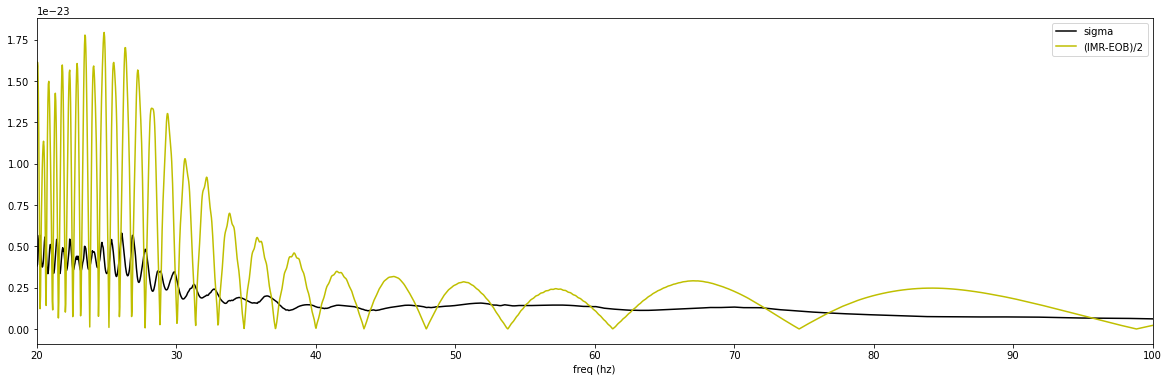

In [30]:
plt.figure(figsize=(20,6))

mode = 'plus'
part = 'real'

testfmin = 20
testfhigh = 400
testmask1 = waveform_generator1.frequency_array>testfmin
testmask2 = waveform_generator1.frequency_array<testfhigh
testmask = testmask1*testmask2

testfreqs = waveform_generator1.frequency_array[testmask]

if part=='real':
    interpolator_surshifted = scipy.interpolate.CubicSpline(farray_shiftedsur, np.real(h_dict_sur_to_shift[mode]))


    sigma = np.real(error_dict[mode][testmask])
    diff1 = abs(np.real(h_dict_imr[mode][testmask]) - np.real(h_dict[mode][testmask]))
    diff2 = abs(np.real(h_dict[mode][testmask]) - interpolator_surshifted(testfreqs))
    diff12 = abs(np.real(h_dict_imr[mode][testmask]) - interpolator_surshifted(testfreqs))
    #pct1 = scipy.special.erf(diff1/sigma/2**0.5)
    #pct2 = scipy.special.erf(diff2/sigma/2**0.5)
    #pct12 = scipy.special.erf(diff12/sigma/2**0.5/2)
    
    plt.plot(testfreqs, sigma, label=f"sigma",color='k')
    #plt.plot(testfreqs, diff1, label=f"IMR-NP",color='b')
    #plt.plot(testfreqs, diff2, label=f"sur-NP",color='r')
    plt.plot(testfreqs, diff12/2, label=f"(IMR-sur)/2",color='y')
    
    plt.legend()
    plt.xlim(20,100)
    
    plt.xlabel('freq (hz)')
    #plt.ylabel('erf')
elif part=='imag':
    pass

# archived

## Single waveform context

In [120]:
duration=32/4
f_lower=10*2
sampling_frequency=4096
ifos = bilby.gw.detector.InterferometerList(['L1'])
det = ifos[0]
det.duration = duration
det.sampling_frequency=sampling_frequency
det.frequency_mask = det.frequency_array>=f_lower
mask = det.frequency_mask
freq_array = det.frequency_array[mask]

injection_parameters = {'chirp_mass': 20,
 'mass_ratio': 1,
 'a_1': 0.48817513918906,
 'a_2': 0.3618136183509149,
 'tilt_1': 1.5721118014736555,
 'tilt_2': 0.6209483780316792,
 'phi_12': 0.497541312882614,
 'phi_jl': 2.727769314864493,
 'theta_jn': 1.2076899194027677,
 'psi': 2.592123436585328,
 'phase': 3.153492039022807,
 'ra': 4.2400911,
 'dec': -0.39120439,
 'luminosity_distance': 320,
 'geocent_time': 1256779567.5339382}

approx = 'IMRPhenomXPHM' # IMRPhenomXPHM IMRPhenomPv2
approx_under = 'SsurNRv4PHM' # SsurNRv4PHM SsurNRv4P
f_ref = 50
f_lower = 20
waveform_arguments = dict(waveform_approximant=approx,
                              reference_frequency=f_ref, minimum_frequency=f_lower)
waveform_arguments_under = dict(waveform_approximant=approx_under,
                              reference_frequency=f_ref, minimum_frequency=f_lower)

waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments)

waveform_generator_under = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments_under)

In [23]:
h_dict_imr = waveform_generator.frequency_domain_strain(injection_parameters)
h_dict_sur = waveform_generator_under.frequency_domain_strain(injection_parameters)

In [24]:
# local
path_local_PHM = '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMRsur_PHM_q25a8M40_2N10k/'
path_local_P = '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMRsur_P_q25a8M40_2N10k/'

# cit
path_cit_PHM = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMRsur_PHM_q25a8M40_2N10k/'
path_cit_P = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMRsur_P_q25a8M40_2N10k/'

np_model_path = path_local_PHM
waveform_generator_np = npgwutils.NPWaveformGenerator(model_path=np_model_path,
                                                      context_waveform_generator=waveform_generator,device='cpu')

waveform_generator_np2 = npgwutils.NPWaveformGenerator(model_path=np_model_path,
                                                       context_waveform_generator=waveform_generator_under,device='cpu')


--- Loading plus_real/ConvCNP/run_0 ---

plus_real/ConvCNP/run_0 | best epoch: 95 | train loss: 8215.8128 | valid loss: 9618.0331 | test log likelihood: -8821.4857

--- Loading plus_imag/ConvCNP/run_0 ---

plus_imag/ConvCNP/run_0 | best epoch: 95 | train loss: 8525.2475 | valid loss: 9923.1221 | test log likelihood: -9354.2217

--- Loading cross_real/ConvCNP/run_0 ---

cross_real/ConvCNP/run_0 | best epoch: 87 | train loss: 10729.9055 | valid loss: 12006.9353 | test log likelihood: -11772.4798

--- Loading cross_imag/ConvCNP/run_0 ---

cross_imag/ConvCNP/run_0 | best epoch: 97 | train loss: 11306.5291 | valid loss: 12728.3657 | test log likelihood: -12339.914

--- Loading plus_real/ConvCNP/run_0 ---

plus_real/ConvCNP/run_0 | best epoch: 95 | train loss: 8215.8128 | valid loss: 9618.0331 | test log likelihood: -8821.4857

--- Loading plus_imag/ConvCNP/run_0 ---

plus_imag/ConvCNP/run_0 | best epoch: 95 | train loss: 8525.2475 | valid loss: 9923.1221 | test log likelihood: -9354.2217



In [25]:
h_dict, error_dict = waveform_generator_np.frequency_domain_strain(injection_parameters)

h_dict2, error_dict2 = waveform_generator_np2.frequency_domain_strain(injection_parameters)

/Users/qianhu/opt/anaconda3/envs/igwn-py39/lib/python3.9/site-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


In [26]:
for key in ['plus', 'cross']:
    h_dict_sur[key] = npgwutils.get_shifted_h2_zeropad(h_dict_imr[key], h_dict_sur[key], det)

(20.0, 40.0)

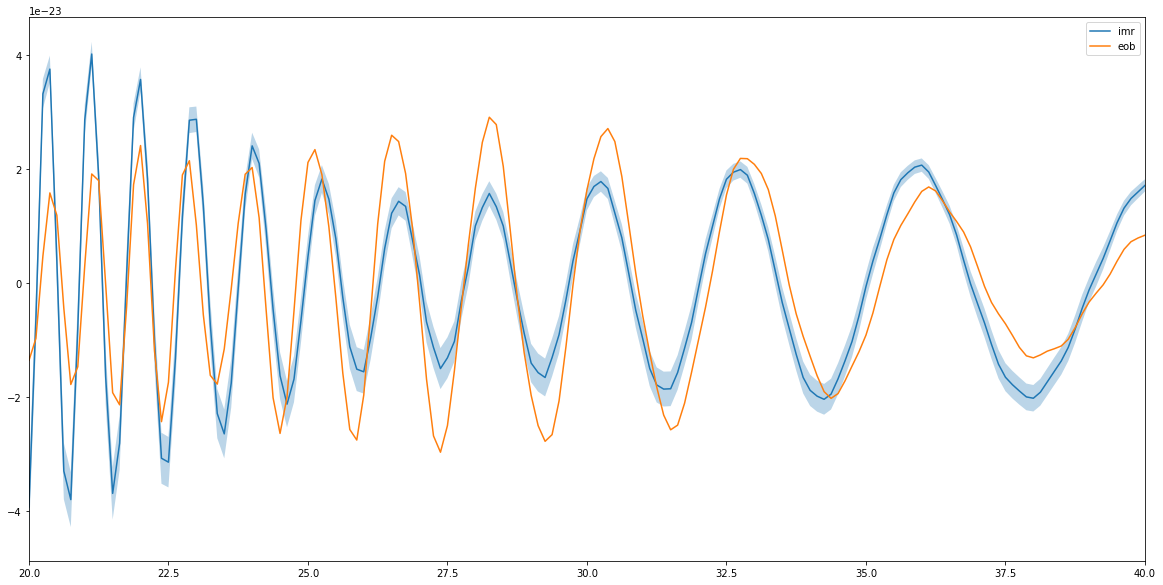

In [27]:
plt.figure(figsize=(20,10))

mode = 'cross'
'''
plt.plot(waveform_generator.frequency_array, np.real(h_dict[mode]), label='np')
plt.fill_between(waveform_generator.frequency_array,
                 np.real(h_dict[mode]-error_dict[mode]),np.real(h_dict[mode]+error_dict[mode]),
                 alpha=0.3 )
'''
plt.plot(waveform_generator.frequency_array, np.real(h_dict_imr[mode]), label='imr')
plt.fill_between(waveform_generator.frequency_array,
                 np.real(h_dict_imr[mode]-error_dict[mode]),np.real(h_dict_imr[mode]+error_dict[mode]),
                 alpha=0.3 )

plt.plot(waveform_generator.frequency_array, np.real(h_dict_sur[mode]), label='sur')

plt.legend()
#plt.xlim(40,100)
plt.xlim(20,40)

(20, 2000)

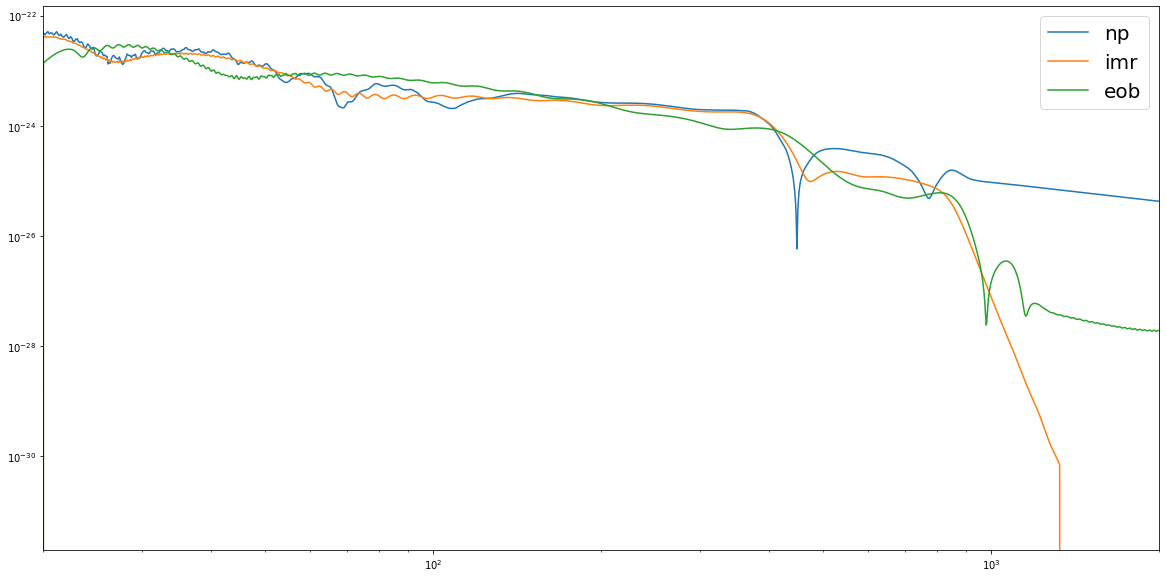

In [28]:
plt.figure(figsize=(20,10))

mode = 'cross'
plt.loglog(waveform_generator.frequency_array, np.abs(h_dict[mode]), label='np')
#plt.fill_between(waveform_generator.frequency_array,
#                 np.real(h_dict[mode]-error_dict[mode]),np.real(h_dict[mode]+error_dict[mode]),
#                 alpha=0.3 )

plt.loglog(waveform_generator.frequency_array, np.abs(h_dict_imr[mode]), label='imr')
#plt.fill_between(waveform_generator.frequency_array,
#                 np.real(h_dict_imr[mode]-error_dict[mode]),np.real(h_dict_imr[mode]+error_dict[mode]),
#                 alpha=0.3 )

plt.loglog(waveform_generator.frequency_array, np.abs(h_dict_sur[mode]), label='sur')

plt.legend(fontsize=20)
plt.xlim(20,2000)

(20.0, 50.0)

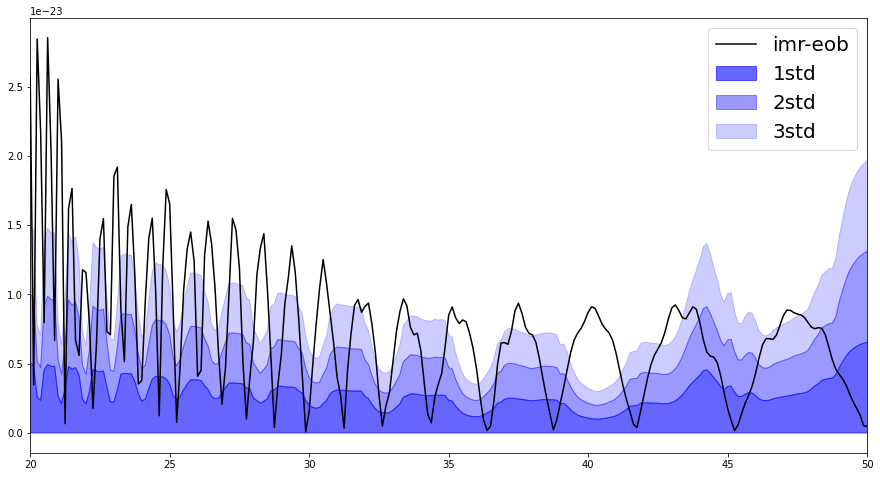

In [29]:
plt.figure(figsize=(15,8))

mode = 'cross'


plt.plot(waveform_generator.frequency_array, abs(np.real(h_dict_imr[mode]-h_dict_sur[mode])), label='imr-sur', color='k')

plt.fill_between(waveform_generator.frequency_array, np.zeros(len(waveform_generator.frequency_array)), np.real(error_dict[mode]), label=f'1std', alpha=0.6, color='b')

plt.fill_between(waveform_generator.frequency_array, np.real(error_dict[mode]),2*np.real(error_dict[mode]), alpha=0.4, color='b', label=f'2std')

plt.fill_between(waveform_generator.frequency_array, 2*np.real(error_dict[mode]),3*np.real(error_dict[mode]), label=f'3std', alpha=0.2, color='b')


plt.legend(fontsize=20)
#plt.xlim(40,100)
plt.xlim(20,50)

In [30]:
for key, errors in error_dict2.items():
    error_dict2[key] = npgwutils.get_shifted_h2_zeropad(error_dict[key], error_dict2[key], det)

(20.0, 50.0)

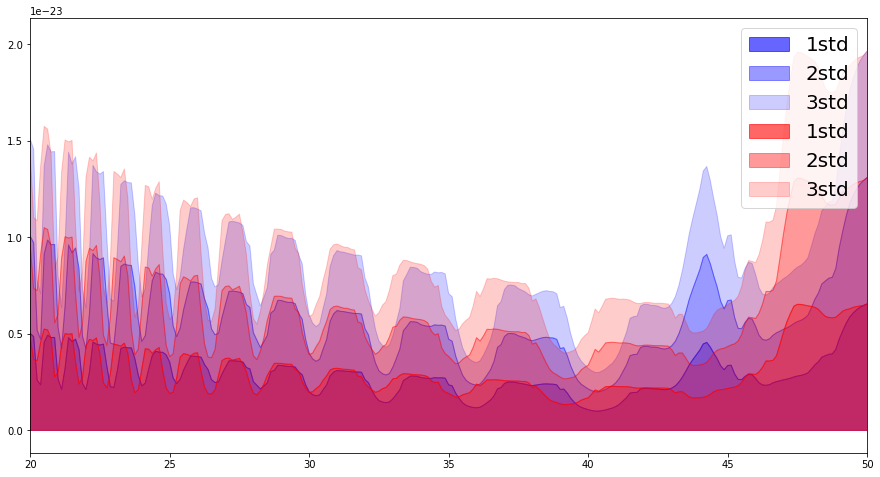

In [31]:
plt.figure(figsize=(15,8))

mode = 'cross'
plt.fill_between(waveform_generator.frequency_array, np.zeros(len(waveform_generator.frequency_array)), np.real(error_dict[mode]), label=f'1std', alpha=0.6, color='b')

plt.fill_between(waveform_generator.frequency_array, np.real(error_dict[mode]),2*np.real(error_dict[mode]), alpha=0.4, color='b', label=f'2std')

plt.fill_between(waveform_generator.frequency_array, 2*np.real(error_dict[mode]),3*np.real(error_dict[mode]), label=f'3std', alpha=0.2, color='b')


plt.fill_between(waveform_generator.frequency_array, np.zeros(len(waveform_generator.frequency_array)), np.real(error_dict2[mode]), label=f'1std', alpha=0.6, color='r')

plt.fill_between(waveform_generator.frequency_array, np.real(error_dict2[mode]),2*np.real(error_dict2[mode]), alpha=0.4, color='r', label=f'2std')

plt.fill_between(waveform_generator.frequency_array, 2*np.real(error_dict2[mode]),3*np.real(error_dict2[mode]), label=f'3std', alpha=0.2, color='r')


plt.legend(fontsize=20)
#plt.xlim(40,100)
plt.xlim(20,50)